In [1]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import pandas as pd
import math
import pycolmap


# plt.rcParams.update({'font.size': 16})


In [2]:
def getAUC(errors, threshold_list):
    auc = []

    for threshold in threshold_list:
        auc.append(np.sum(errors < threshold)/len(errors))

    return auc

In [3]:
def plotCDF_all(results, method_names, skip_name = []):
    method_names_ = method_names.copy()
    error_names = ['R Error (deg)', 't Error (cm)', 'f Error (%)', 'Runtime (ms)', 'Iterations', 'Num Inliers']
    error_limits = [50, 50, 200, 1000]
    n = len(method_names)

    plt.figure(figsize=(10, 6))
    for i in range(len(error_names)):
        plt.subplot(2, 3, i+1)
        for j in range(n):
            if method_names[j] in skip_name:
                continue
            sns.ecdfplot(results[:,i+j*6])
        plt.xlabel(error_names[i])
        plt.ylabel('CDF')

    for name_ in method_names:
        if name_ in skip_name:
            method_names_.remove(name_)

    plt.legend(method_names_)
    plt.tight_layout()
    plt.show()



In [4]:
def collectErrors(errors, method_names):
    assert len(errors[list(errors.keys())[0]]) == len(method_names)*6

    results = []
    for query_name in errors.keys():
        results.append(errors[query_name])
    results = np.array(results)

    return results

In [5]:
def showErrors(errors, method_names):
    
    top_level_headers = ['R Error (deg)', 't Error (cm)', 'f Error (%)', 'Runtime (ms)', 'Iterations', 'Num Inliers']

    table = np.reshape(errors, (len(method_names), 6))
    df = pd.DataFrame(table, columns=top_level_headers, index=method_names)

    return df

In [6]:
def getAUC(errors, R_idx, t_idx, R_thrs, t_thrs):
    n = errors.shape[0]
    assert len(R_thrs) == len(t_thrs)
    
    auc = []
    for j in range(len(R_thrs)):
        auc_ = 0
        for i in range(n):
            if errors[i,R_idx] < R_thrs[j] and errors[i,t_idx] < t_thrs[j]:
                auc_ += 1
        auc.append(auc_/n)
    return auc

# Dataset statistics

In [31]:
scene_list = ["festia_out_corridor", "sportunifront", "parakennus_out", "main_campus", "Kitchen_In", "meetingroom", "night_out", "outcorridor", "parakennus", "upstairs"]

# larger sequence 0, 1, 3, 9
scene = scene_list[2]
gt_dirs = Path("/home2/xi5511zh/Xinyue/Datasets/Fisheye_FIORD")
results_dir = gt_dirs / scene / "processed_remove_neighbours/hloc/RANSACresults_remove_neighbours.pkl"
method_names = ['p3p', 'P4Pfr', 'P4Pfr_LM', 'P4Pfr_HC_pose', 'P4Pfr_HC_depth', 'P3P_sampling_LM', 'P3P_sampling_HC', 'P5Pfr', 'P5Pfr_LM']


# load results

In [32]:
with open(results_dir, 'rb') as f:
    errors = pickle.load(f)
results = collectErrors(errors, method_names)

In [33]:
medianError = np.median(results, axis=0)
df_median = showErrors(medianError, method_names)
df_median

,R Error (deg),t Error (cm),f Error (%),Runtime (ms),Iterations,Num Inliers
p3p,4.116694,57.549526,0.000000,11.698823,101.0,2130.0
P4Pfr,0.577567,9.472497,16.277558,894.655671,1689.0,728.0
P4Pfr_LM,0.587773,9.585005,18.458294,213.921276,1669.0,722.0
P4Pfr_HC_pose,0.578135,9.585005,10.705743,407.676626,1689.0,726.0
P4Pfr_HC_depth,0.577567,9.371493,13.095842,316.583335,1689.0,723.0
P3P_sampling_LM,0.568992,10.998310,14.987570,342.892136,1640.0,723.0
P3P_sampling_HC,0.577567,8.828329,13.619228,974.182565,1689.0,726.0
P5Pfr,0.577567,6.205034,15.173000,569.231005,2000.0,724.0
P5Pfr_LM,0.577567,9.522082,16.261493,111.230412,2000.0,726.0


In [34]:
meanError = np.mean(results, axis=0)
df_mean = showErrors(meanError, method_names)
df_mean

,R Error (deg),t Error (cm),f Error (%),Runtime (ms),Iterations,Num Inliers
p3p,5.345333,81.635017,0.000000,12.550980,101.000000,2025.925926
P4Pfr,2.233542,24.903947,38.299617,795.548844,1428.555556,720.555556
P4Pfr_LM,2.227967,25.245711,40.382398,195.041816,1430.111111,723.296296
P4Pfr_HC_pose,1.956600,24.335671,35.180165,392.529542,1431.222222,724.259259
P4Pfr_HC_depth,1.932987,23.830017,35.895357,316.701475,1430.370370,721.259259
P3P_sampling_LM,2.252339,25.242706,38.761892,295.369999,1419.185185,723.962963
P3P_sampling_HC,2.080606,24.732781,37.153031,844.008585,1429.666667,724.407407
P5Pfr,1.862039,23.414747,40.343304,531.954637,1836.074074,721.222222
P5Pfr_LM,2.037601,24.812343,38.498438,121.794959,1835.777778,720.814815


# AUC

In [35]:
R_thr = [1, 1, 2, 5, 5]
t_thr = [1, 2, 5, 5, 10]
f_thr = [1, 2, 5, 10, 50]

In [36]:
AUC = []
for m_idx in range(len(method_names)):
    auc_ = getAUC(results, m_idx*6, m_idx*6+1, R_thr, t_thr)
    AUC.append({'method': method_names[m_idx], f"{R_thr[0]}deg, {t_thr[0]}cm": f"{auc_[0]*100:.2f}", 
        f"{R_thr[1]}deg, {t_thr[1]}cm": f"{auc_[1]*100:.2f}", f"{R_thr[2]}deg, {t_thr[2]}cm": f"{auc_[2]*100:.2f}",
        f"{R_thr[3]}deg, {t_thr[3]}cm": f"{auc_[3]*100:.2f}", f"{R_thr[4]}deg, {t_thr[4]}cm": f"{auc_[4]*100:.2f}", "mean time (ms)": f"{results[m_idx, m_idx*6+3]:.2f}"})
AUC = pd.DataFrame(AUC)
AUC


,method,"1deg, 1cm","1deg, 2cm","2deg, 5cm","5deg, 5cm","5deg, 10cm",mean time (ms)
0,p3p,0.00,0.00,0.00,0.00,0.00,3.70
1,P4Pfr,0.00,11.11,40.74,40.74,55.56,1152.11
2,P4Pfr_LM,0.00,11.11,40.74,40.74,51.85,164.37
3,P4Pfr_HC_pose,0.00,14.81,44.44,44.44,55.56,208.42
4,P4Pfr_HC_depth,0.00,11.11,44.44,44.44,55.56,342.36
5,P3P_sampling_LM,0.00,11.11,40.74,40.74,48.15,149.13
6,P3P_sampling_HC,0.00,11.11,44.44,44.44,51.85,533.92
7,P5Pfr,0.00,14.81,48.15,48.15,62.96,283.15
8,P5Pfr_LM,0.00,7.41,37.04,37.04,51.85,70.11


In [37]:
AUC = []
for m_idx in range(len(method_names)):
    auc_ = getAUC(results, m_idx*6+1, m_idx*6+2, t_thr, f_thr)
    AUC.append({'method': method_names[m_idx], f"{R_thr[0]}cm, {t_thr[0]}px": f"{auc_[0]*100:.2f}", 
        f"{R_thr[1]}cm, {t_thr[1]}px": f"{auc_[1]*100:.2f}", f"{R_thr[2]}cm, {t_thr[2]}px": f"{auc_[2]*100:.2f}", 
        f"{R_thr[3]}cm, {t_thr[3]}px": f"{auc_[3]*100:.2f}", f"{R_thr[4]}cm, {t_thr[4]}px": f"{auc_[4]*100:.2f}", "mean time (ms)": f"{results[m_idx, m_idx*6+3]:.2f}"})
AUC = pd.DataFrame(AUC)
AUC

,method,"1cm, 1px","1cm, 2px","2cm, 5px","5cm, 5px","5cm, 10px",mean time (ms)
0,p3p,0.00,0.00,0.00,0.00,0.00,3.70
1,P4Pfr,0.00,0.00,25.93,29.63,55.56,1152.11
2,P4Pfr_LM,0.00,0.00,22.22,25.93,48.15,164.37
3,P4Pfr_HC_pose,0.00,0.00,33.33,33.33,51.85,208.42
4,P4Pfr_HC_depth,0.00,0.00,22.22,29.63,51.85,342.36
5,P3P_sampling_LM,0.00,0.00,22.22,25.93,48.15,149.13
6,P3P_sampling_HC,0.00,3.70,29.63,33.33,48.15,533.92
7,P5Pfr,0.00,0.00,29.63,33.33,62.96,283.15
8,P5Pfr_LM,0.00,0.00,22.22,29.63,48.15,70.11


# Error CDF

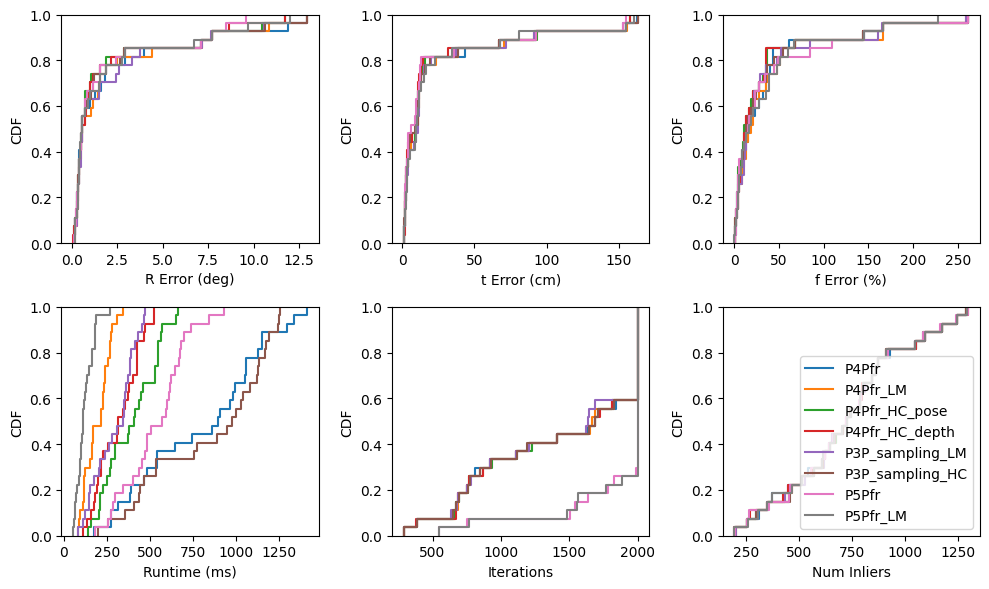

In [38]:
plotCDF_all(results, method_names, 'p3p')

# check individual error

In [39]:
query_name_list = list(errors.keys())
query_name = query_name_list[16]

In [40]:
corrs = gt_dirs / scene / "processed_remove_neighbours/Corrs/CorrsDict.pkl"
with open(corrs, 'rb') as f:
    corrs = pickle.load(f)
corrs[query_name]['imageID']


363

In [41]:
query_name = 'cam1/IMG_20250330_115955_00_235_fisheye1.jpg'

In [42]:
df = showErrors(errors[query_name], method_names)
df

,R Error (deg),t Error (cm),f Error (%),Runtime (ms),Iterations,Num Inliers
p3p,2.004751,42.929622,0.000000,4.553860,101.0,1733.0
P4Pfr,0.384175,9.503316,39.799825,981.095027,2000.0,373.0
P4Pfr_LM,0.290921,4.845837,12.859216,226.091767,2000.0,435.0
P4Pfr_HC_pose,0.370426,4.656506,4.907071,434.280983,2000.0,460.0
P4Pfr_HC_depth,0.066989,1.975212,13.095842,342.355345,2000.0,425.0
P3P_sampling_LM,0.290921,4.845837,12.859216,342.892136,2000.0,435.0
P3P_sampling_HC,0.370426,4.656506,4.907071,1175.942442,2000.0,460.0
P5Pfr,0.213810,3.637726,16.552206,482.418518,2000.0,460.0
P5Pfr_LM,0.465634,5.142569,8.912385,75.853889,2000.0,376.0
